In [57]:
from transformers import ViTImageProcessor

In [47]:
from datasets import load_dataset
datasets = load_dataset("beans").remove_columns("image_file_path")

In [48]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 128
    })
})

In [49]:
datasets = datasets.rename_column("labels", "label")
train_ds = datasets["train"]
val_ds = datasets["validation"]
test_ds = datasets["test"]

In [50]:
import numpy as np
np.array(training_dataset[0]["image"]).shape

(500, 500, 3)

In [58]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [51]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size, scale=(0.6, 1.0)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [52]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [53]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'label': 0,
 'pixel_values': tensor([[[-0.5451, -0.3569,  0.0118,  ..., -0.8275, -0.8588, -0.8275],
          [-0.5608, -0.3882, -0.0431,  ..., -0.7725, -0.8275, -0.8196],
          [-0.6000, -0.4196, -0.0588,  ..., -0.7176, -0.7882, -0.7333],
          ...,
          [-0.7569, -0.7490, -0.7569,  ...,  0.7255,  0.7333,  0.6941],
          [-0.7725, -0.7412, -0.7490,  ...,  0.7020,  0.7255,  0.7098],
          [-0.7490, -0.7490, -0.7490,  ...,  0.6471,  0.7098,  0.7020]],
 
         [[-0.7647, -0.6235, -0.2863,  ..., -0.9451, -0.9451, -0.9059],
          [-0.7725, -0.6471, -0.3412,  ..., -0.9059, -0.9373, -0.9294],
          [-0.8039, -0.6784, -0.3647,  ..., -0.8588, -0.9216, -0.8667],
          ...,
          [-0.9137, -0.9216, -0.9373,  ...,  0.3255,  0.3333,  0.2941],
          [-0.9529, -0.9216, -0.9216,  ...,  0.2941,  0.3098,  0.2941],
          [-0.9294, -0.9216, -0.9216,  ...,  0.2392,  0.2941,  0.2941]]

In [54]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [62]:
from transformers import ViTForImageClassification
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-beans",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [67]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [68]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [69]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.226801,0.969925
2,No log,0.117156,0.992481
3,No log,0.113063,0.984962


TrainOutput(global_step=312, training_loss=0.28502337137858075, metrics={'train_runtime': 80.7738, 'train_samples_per_second': 38.404, 'train_steps_per_second': 3.863, 'total_flos': 2.4038230623573197e+17, 'train_loss': 0.28502337137858075, 'epoch': 3.0})

In [75]:
outputs = trainer.predict(test_ds)

In [76]:
outputs.metrics

{'test_loss': 0.17288607358932495,
 'test_accuracy': 0.9609375,
 'test_runtime': 0.9272,
 'test_samples_per_second': 138.049,
 'test_steps_per_second': 34.512}

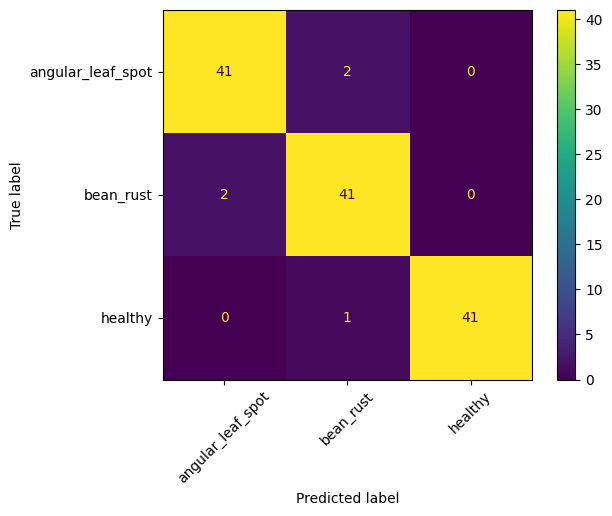

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)